AI - TP1_2

Bastien SAUVAT et Bastien FAISANT

# Exercise 1 : Building a neural network to classify texts (multi-layer perceptron (MLP))

*Objective : Understand the notion of over-fitting and under-fitting.*

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras import regularizers
import re
import string
import matplotlib.pyplot as plt

## Load and explore the dataset

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


The IMDB movie review dataset contains 50 000 movie reviews and their corresponding sentiments (positive or negative).

## Data Preprocessing

### Split Dataset

In [5]:
x_data = df['review']
y_data = df['sentiment']

# Encode sentiment 
y_data = y_data.replace('positive', 1)
y_data = y_data.replace('negative', 0)


The sentiment labels (positive and negative) are converted to binary values (1 for positive, 0 for negative). Then, the dataset is split into training (80%), validation (10%) and test (10%) sets.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')

Train Set
20547    I went to this film having no idea what to exp...
7110     More directors like Nacho Vigalondo need a gre...
34763    Twelve Monkeys is an insane time-travelling, a...
33616    The original Vampires (1998) is one of my favo...
4749     This parody is cleverly done: from the songs (...
                               ...                        
879      Largely forgettable tale in which mercenary Ke...
49619    Spoilers <br /><br />Well, the one line summar...
45266    I was supremely disappointed with this one. Ha...
47123    Wallace and Gromit are the main characters in ...
16942    This isn't art, it's inner-urban, politically-...
Name: review, Length: 40000, dtype: object 

47908    This last Dutch speaking film of Verhooven mad...
9513     This was one of the all time best episodes. Of...
31952    This film was original in an unoriginal way. A...
44990    Mean spirited, and down right degrading adapta...
37079    If it's action and adventure you want in a mov...
 

### Standardization

The standardization function converts text to lowercase and removes HTML tags (like `<br />`) and punctuation from the text.

In [7]:
def standardization(data):
    lowercase = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

### Tokenization and Vectorization

The text is tokenized and vectorized using the `TextVectorization` layer. It standardizes the text using the `standardization` function, limits the vocabulary size to 10 000 words (or tokens), and pads sequence to a fixed length of 250.<br>This step prepares the text for input to the neural network.

In [8]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
vectorize_layer.adapt(x_train)

x_train = vectorize_layer(x_train)
x_test = vectorize_layer(x_test)
x_val = vectorize_layer(x_val)

## Create the model

The neural network model is created using Keras. The model includes the following layers :
- Embedding layer with an embedding dimension of 16
- Dropout layer 1 (to prevent overfitting)
- GlobalAveragePooling1D layer for pooling
- Dropout layer 2
- Dense layer with a single output unit for binary classification

In [10]:
embedding_dim = 16

In [11]:
model = tf.keras.Sequential([
  Embedding(max_features + 1, embedding_dim),
  Dropout(0.2),
  GlobalAveragePooling1D(),
  Dropout(0.2),
  Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The model is compiled with the 'adam' optimizer and binary cross-entropy loss for binary classification. The accuracy metric is used for evaluation.

### Train the Model

In [15]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3113 - accuracy: 0.8877 - val_loss: 0.3854 - val_accuracy: 0.8870
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2859 - accuracy: 0.8997 - val_loss: 0.3867 - val_accuracy: 0.8878
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2836 - accuracy: 0.9001 - val_loss: 0.3832 - val_accuracy: 0.8894
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2626 - accuracy: 0.9068 - val_loss: 0.3931 - val_accuracy: 0.8920
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2574 - accuracy: 0.9104 - val_loss: 0.4024 - val_accuracy: 0.8898


### Evaluate Model Performance

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

157/157 [==============================] - 0s 1ms/step - loss: 0.3657 - accuracy: 0.8926
Loss:  0.3657446801662445
Accuracy:  0.8925999999046326


```python
model = tf.keras.Sequential([
  Embedding(max_features + 1, embedding_dim),
  Dropout(0.2),
  GlobalAveragePooling1D(),
  Dropout(0.2),
  Dense(1)])
```
With this model, the results show that the model achieves an accuracy of approximately 89.26% on the test data, and the loss is around 0.36.

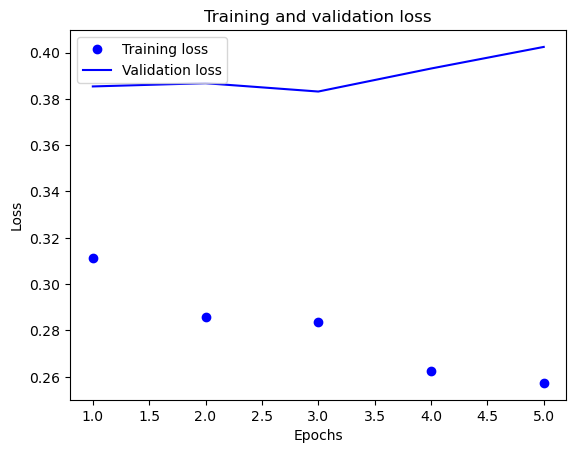

In [17]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

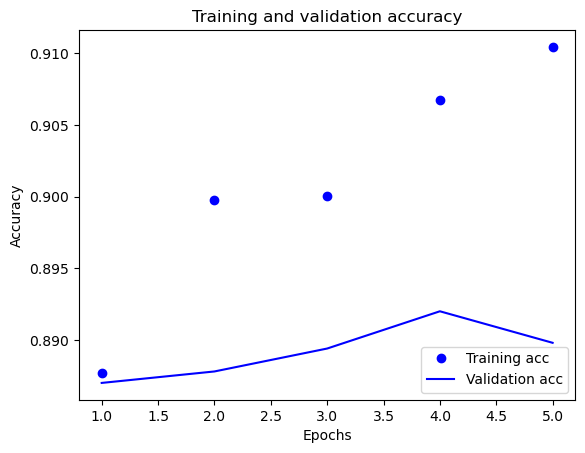

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Demonstrate the effects of over-fitting

In [19]:
def compile_and_fit(model, optimizer='adam', epochs=10):
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val))
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    return history

In [20]:
size_histories = {}

In [21]:
# Define a baseline tiny model
tiny_model = tf.keras.Sequential([
  Embedding(max_features + 1, 16),
  GlobalAveragePooling1D(),
  Dense(1, activation='sigmoid')
])

# Train and evaluate the tiny model
size_histories['Tiny'] = compile_and_fit(tiny_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5972 - accuracy: 0.7507 - val_loss: 0.4866 - val_accuracy: 0.8224
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4028 - accuracy: 0.8547 - val_loss: 0.3671 - val_accuracy: 0.8610
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3215 - accuracy: 0.8782 - val_loss: 0.3201 - val_accuracy: 0.8710
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2815 - accuracy: 0.8913 - val_loss: 0.2967 - val_accuracy: 0.8792
Epoch 5/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2557 - accuracy: 0.9012 - val_loss: 0.2835 - val_accuracy: 0.8872
Epoch 6/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2369 - accuracy: 0.9093 - val_loss: 0.2769 - val_accuracy: 0.8918
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2222 - accuracy: 0.9149 - val_loss: 0.2773 - val_accuracy:

In [22]:
# Define a medium model
medium_model = tf.keras.Sequential([
  Embedding(max_features + 1, 64),
  GlobalAveragePooling1D(),
  Dense(32, activation='relu'),
  Dense(16, activation='relu'),
  Dense(8, activation='relu'),
  Dense(1, activation='sigmoid')
])


# Train and evaluate the medium model
size_histories['Medium'] = compile_and_fit(medium_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640064    
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                      

In [23]:
# Define a large model
large_model = tf.keras.Sequential([
  Embedding(max_features + 1, 128),
  GlobalAveragePooling1D(),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(16, activation='relu'),
  Dense(8, activation='relu'),
  Dense(1, activation='sigmoid')
])


# Train and evaluate the large model
size_histories['Large'] = compile_and_fit(large_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280128   
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                      

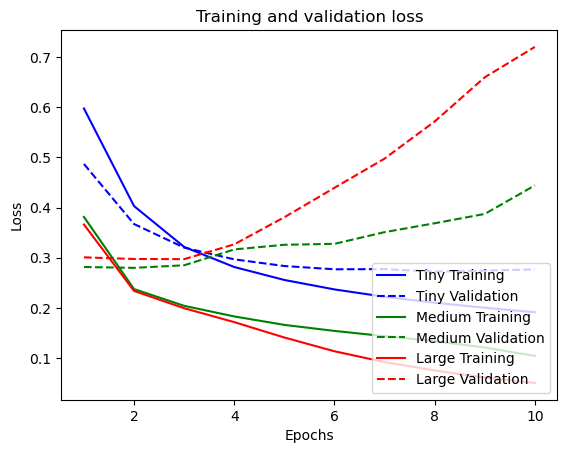

In [30]:
colors = ['b', 'g', 'r']

for i, history in enumerate(size_histories):
    color = colors[i % len(colors)]
    plt.plot(range(1,11), size_histories[history].history['loss'], color=color, label=history+' Training')
    plt.plot(range(1,11), size_histories[history].history['val_loss'], color=color, linestyle='dashed', label=history+' Validation')


plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

This graph illustrates the performance of the 3 models—Tiny, Medium, and Large—across various epochs, displaying their loss values for both the training and validation sets.<br>
The Tiny model exhibits closely aligned curves for both training and validation sets, indicating consistent behavior. However, with the Medium and Large models, a divergence occurs: while the training loss steadily decreases across epochs, the validation loss starts increasing beyond a certain point. This discrepancy suggests a potential issue with overfitting for Medium and Large models.Indeed, they may excel in fitting to the training data but struggle to generalize well to unseen data, resulting in increased validation loss.

As the model size increases from Tiny to Medium and Large, the running time also escalates significantly during training. Larger models with more parameters demand more computational resources, causing longer training durations. This increase in network size directly correlates with extended training times for each epoch.

### Prevent overfitting

In [25]:
reg_histories = {}
reg_histories['Large'] = size_histories['Large']

In [28]:
# Define a l2 model
l2_model = tf.keras.Sequential([
  Embedding(max_features + 1, 128),
  GlobalAveragePooling1D(),
  Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  Dense(1, activation='sigmoid')
])


# Train and evaluate the large model
reg_histories['L2'] = compile_and_fit(l2_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         1280128   
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                      

In [31]:
# Define a dropout model
dropout_model = tf.keras.Sequential([
  Embedding(max_features + 1, 128),
  GlobalAveragePooling1D(),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(16, activation='relu'),
  Dropout(0.5),
  Dense(8, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid')
])


# Train and evaluate the large model
reg_histories['Dropout'] = compile_and_fit(dropout_model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1280128   
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

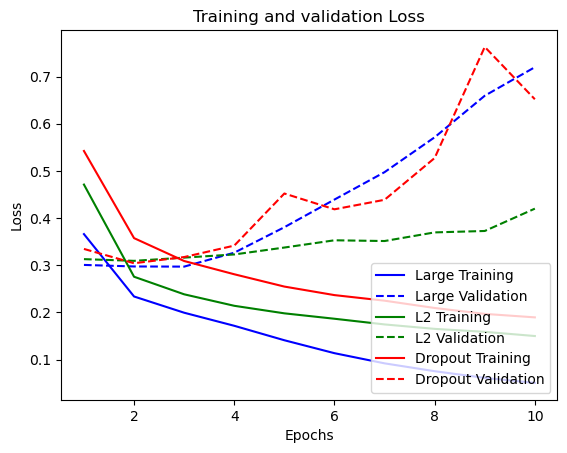

In [38]:
colors = ['b', 'g', 'r', 'c', 'm']

for i, history in enumerate(reg_histories):
    color = colors[i % len(colors)]
    plt.plot(range(1,11), reg_histories[history].history['loss'], color=color, label=history+' Training')
    plt.plot(range(1,11), reg_histories[history].history['val_loss'], color=color, linestyle='dashed', label=history+' Validation')


plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

Regularization techniques such as Dropout and L2 regularization applied to the Large Model effectively mitigate overfitting issues by introducing constraints during training, leading to improved generalization on unseen data.<br>
Despite this, it's noteworthy that the Tiny Model, despite its simplicity, maintains higher performance levels. While regularization enhances the Large Model's ability to generalize, the Tiny Model's inherent simplicity enables it to outperform, highlighting the balance between model complexity, regularization, and performance.